In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp 
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve, auc
from tensorflow.python.training import moving_averages
import math

2024-08-19 14:25:54.299347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 14:25:54.345086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 14:25:55.320244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_pred-y_true), axis=[1, 2, 3])
    

In [5]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(48, 48, 1))
    x = layers.BatchNormalization()(encoder_inputs)
    x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 4, activation="relu", strides=2, padding="same")(x)

    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(
        x
    )
    x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 4, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(48, 48, 1))
    x = layers.BatchNormalization()(encoder_inputs)
    x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, (3,3), activation="relu", strides=2, padding="same")(x)
    
    

    encoder_outputs = layers.Conv2D(latent_dim, (1,1), padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(256, (3,3), activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(128, (3,3), activation="relu", strides=2, padding="same")(
        x
    )
    x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(
        x
    )
    x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, (3,3), padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")
 
def get_ae(latent_dim):
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(48, 48, 1))
    
    encoder_outputs = encoder(inputs)
    reconstructions = decoder(encoder_outputs)
    
    return keras.Model(inputs, reconstructions)

In [6]:
with h5py.File('data/q_dataset.h5', 'r') as file:
    full_data = np.array(file['Data'])
    x_train, x_test = train_test_split(full_data, test_size=0.2, shuffle=True)

In [7]:
model = get_ae(16)
model.compile(loss=mse_loss, optimizer=keras.optimizers.Adam())
print(x_train.shape)
model.fit(x_train, x_train, epochs=40, batch_size=256, callbacks=[
    keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, min_delta = 0.00),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)])

2024-08-19 14:27:44.895453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:ca:00.0, compute capability: 8.9


(111880, 48, 48, 1)
Epoch 1/40


I0000 00:00:1724077669.841081     201 service.cc:145] XLA service 0x7ff6d8008800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724077669.841117     201 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-08-19 14:27:49.896438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-19 14:27:50.147503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


 27/438 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.5712e-04

I0000 00:00:1724077673.222197     201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 3.1002e-04 - learning_rate: 0.0010
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7800e-05 - learning_rate: 0.0010
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7747e-05 - learning_rate: 0.0010
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0809e-05 - learning_rate: 0.0010
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.4849e-06 - learning_rate: 0.0010
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.6108e-06 - learning_rate: 0.0010
Epoch 7/40
432/438 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8938e-06
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.8896e-06 - learning_rate: 0.0010
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.6210e-06 - learning_rate: 1.0000e-04
Epoch 9/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.4187e-06 - learning_rate: 1.0000e-04
Epoch 10/

In [10]:
vqvae = model
bkg_prediction = vqvae.predict(x_test)
signal_labels = ["g", "t", "w", "z"]

signals_file = ["data/g_dataset.h5", "data/t_dataset.h5","data/w_dataset.h5","data/z_dataset.h5"]
signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)
    
signal_results = []
for i, label in enumerate(signal_labels):
    signal_prediction = vqvae.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction])

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 925us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 868us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 938us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 925us/step


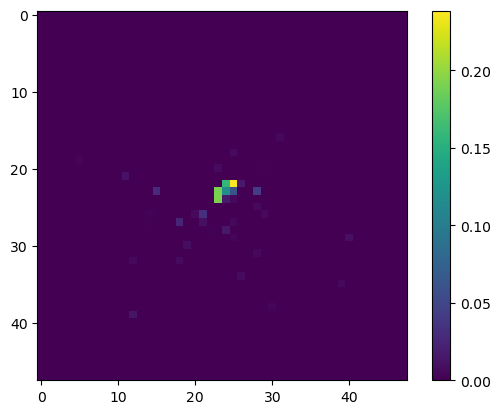

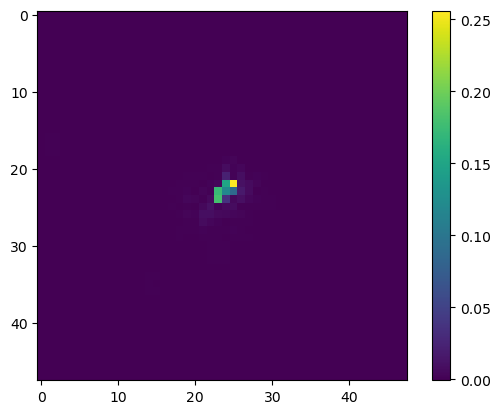

In [11]:
i = 45
# plt.imshow(x_test[i])
# plt.colorbar()
# plt.show()
# plt.imshow(bkg_prediction[i])


# plt.colorbar()
# plt.show()

plt.imshow(signal_results[0][1][i])
plt.colorbar()
plt.show()
plt.imshow(signal_results[0][2][i])

plt.colorbar()
plt.show()

In [12]:
total_loss = []
total_loss.append(mse_loss(x_test.astype('float32'), bkg_prediction.astype('float32')).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss(signal_X, signal_results[i][2]).numpy())

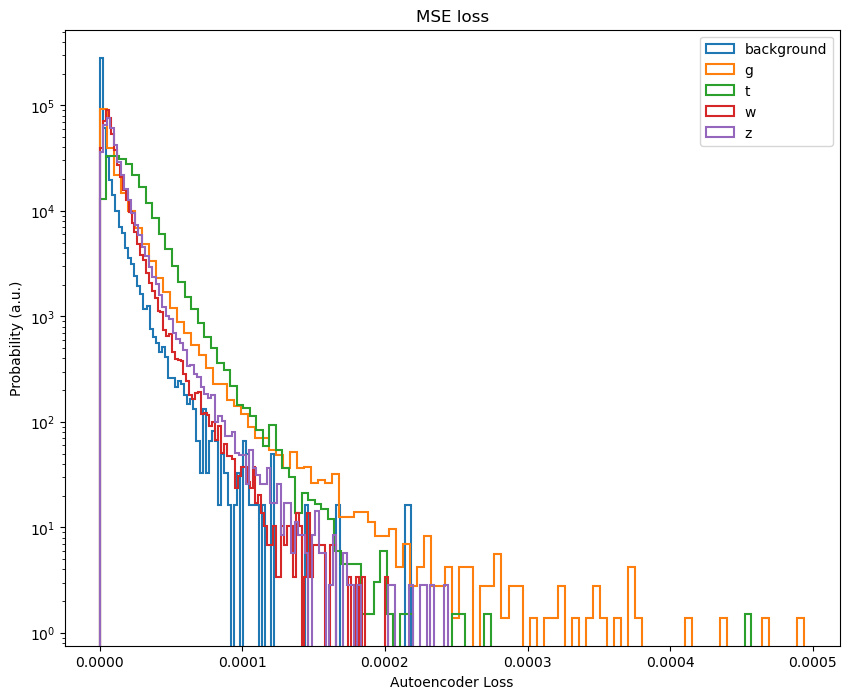

In [13]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "g", "t", "w", "z"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )#range=[0, 3e4])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, 'AE')

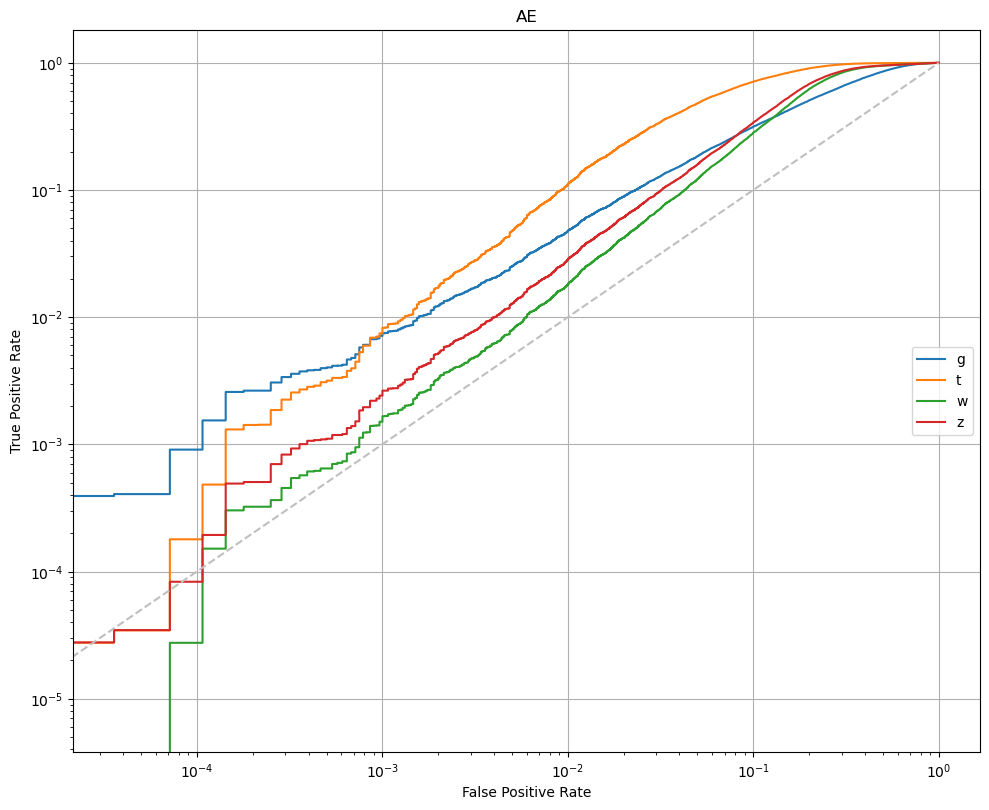

In [14]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
#plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title("AE")
#plt.savefig(output_file+'_roc.jpg')
#plt.show()

In [15]:
encoder = get_encoder(16)


In [16]:
labels = ["q", "g", "t", "w", "z"]

files = ["data/q_dataset.h5", "data/g_dataset.h5", "data/t_dataset.h5","data/w_dataset.h5","data/z_dataset.h5"]
data = []

for i, label in enumerate(labels):
    with h5py.File(files[i], 'r') as file:
        test_data = np.array(file['Data'])
    encoded_outputs = encoder.predict(test_data)
    #flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
    #codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

    #quantized = quantizer.quantize(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
    
    data.append(encoded_outputs)
    #data.append(tf.reshape(codebook_indices, tf.shape(encoded_outputs)[:-1]))
label_list = []
for i, label in enumerate(labels):
    label_list.extend([label] * len(data[i]))

4371/4371 ━━━━━━━━━━━━━━━━━━━━ 4s 863us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 838us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 827us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 857us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 844us/step


In [17]:
data = np.concatenate(data)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# model = keras.models.Sequential([
#     keras.Input(shape=(6,6,16,1)),
#     layers.Conv3D(64, (5,5,5), activation='relu'),
#     layers.MaxPooling3D((1,1,2)),
#     layers.Flatten(),
#     layers.BatchNormalization(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(labels), activation='softmax')
# ])


model = keras.models.Sequential([
    keras.Input(shape=(3,3,16, 1)),
    layers.Conv3D(64, (2,2,2), activation='relu'),
    layers.MaxPooling3D((1,1,2)),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='softmax')
])


# model = keras.models.Sequential([
#     keras.Input(shape=(3,3,1)),
#     #layers.Conv2D(64, (3,3),padding='same', activation='relu'),
#     layers.Flatten(),
#     layers.BatchNormalization(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(16, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(labels), activation='softmax')
# ])



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=256, validation_split=0.1)

Epoch 1/5
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4518 - loss: 1.3047 - val_accuracy: 0.5424 - val_loss: 1.1429
Epoch 2/5
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5397 - loss: 1.1578 - val_accuracy: 0.2290 - val_loss: 8.2924
Epoch 3/5
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5548 - loss: 1.1298 - val_accuracy: 0.5806 - val_loss: 1.0803
Epoch 4/5
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5625 - loss: 1.1171 - val_accuracy: 0.5858 - val_loss: 1.0668
Epoch 5/5
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5679 - loss: 1.1080 - val_accuracy: 0.5798 - val_loss: 1.0763


4500/4500 ━━━━━━━━━━━━━━━━━━━━ 4s 722us/step - accuracy: 0.5780 - loss: 1.0731
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 3s 695us/step


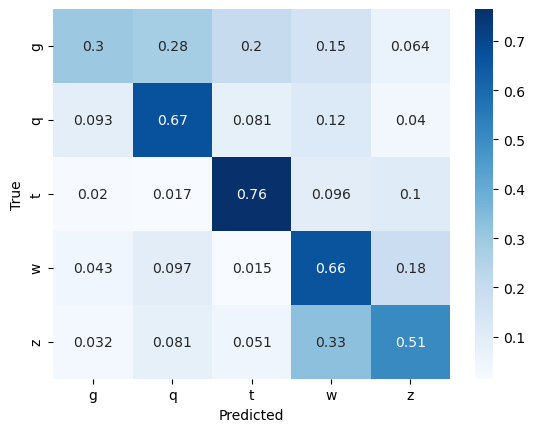

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

loss, accuracy = model.evaluate(X_test, y_test)


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


cm = confusion_matrix(y_test, y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

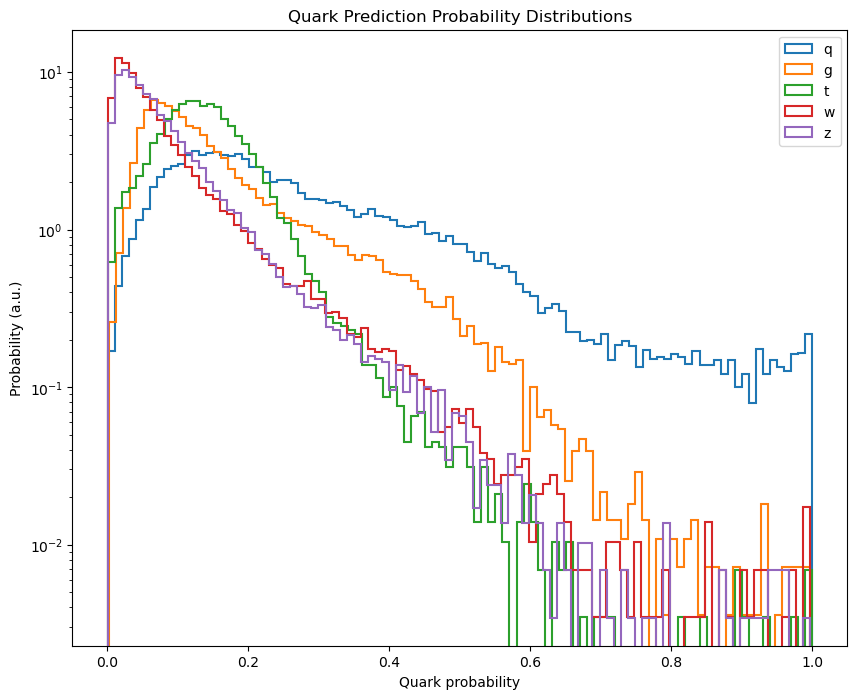

In [22]:
import numpy as np
from matplotlib import pyplot as plt

labels = ["q", "g", "t", "w", "z"]
quark_probabilities = y_pred[:, 0]


bin_size = 100

plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    class_prob = quark_probabilities[y_test == i]
    
    plt.hist(class_prob, bins=bin_size, label=label, density=True, histtype='step', fill=False, linewidth=1.5)

plt.yscale('log')
plt.xlabel('Quark probability')
plt.ylabel('Probability (a.u.)')
plt.title('Quark Prediction Probability Distributions')
plt.legend(loc='best')
plt.show()

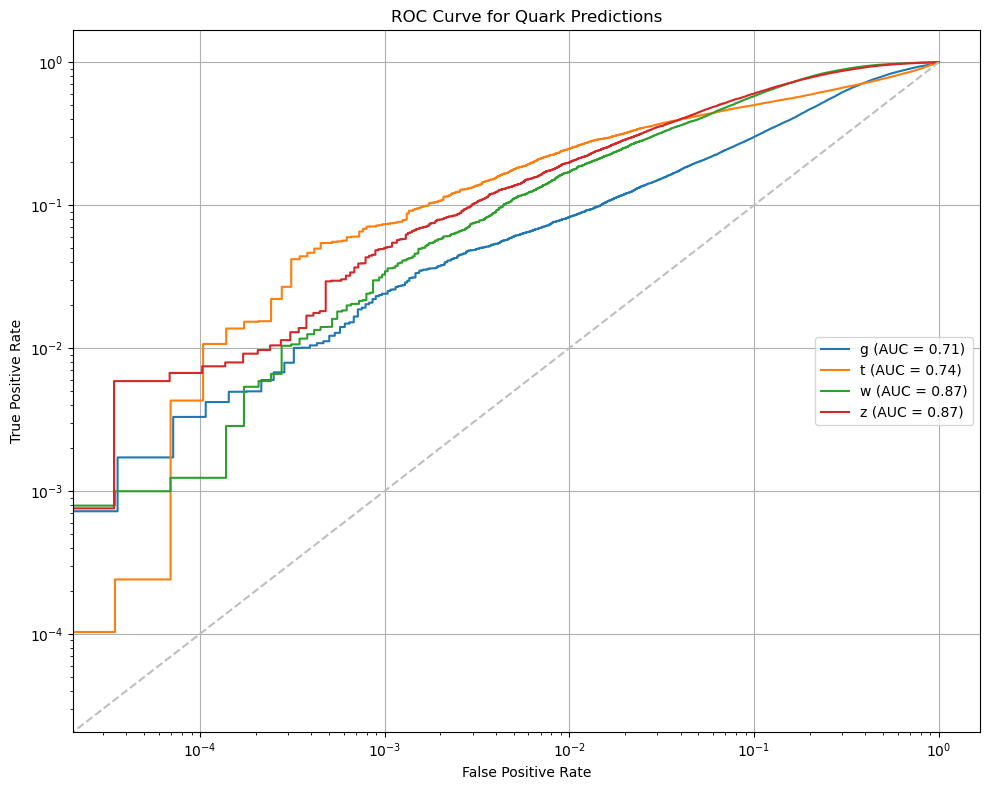

In [23]:
# Define labels and background
signal_labels = ["background", "g", "t", "w", "z"]
background_label = 0  # Assuming 'q' is the background class

# Initialize target for background
target_background = np.zeros(np.sum(y_test == background_label))

# Prepare the figure
plt.figure(figsize=(10, 8))


for i, label in enumerate(signal_labels):
    if i == background_label:
        continue  # Skip background events
    
    trueVal = np.concatenate((np.ones(np.sum(y_test == i)), target_background))  # anomaly=1, bkg=0
    predVal_loss = np.concatenate((quark_probabilities[y_test == i], quark_probabilities[y_test == background_label]))

    tpr_loss, fpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)
    auc_loss = auc(fpr_loss, tpr_loss)
    
    plt.plot(fpr_loss, tpr_loss, "-", linewidth=1.5, label=f'{label} (AUC = {auc_loss:.2f})')
    
plt.semilogx()
plt.semilogy()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Quark Predictions')
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.show()

In [84]:
def get_model(latent_dim=16):
    latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
    #x = layers.BatchNormalization()(latent_inputs)
    x = layers.Conv3D(filters=1, kernel_size=(1, 1, 16), padding='valid', activation='relu')(latent_inputs)
    x = layers.Flatten()(x)

    x = layers.Dense(5, activation='relu')(x)

    x = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(latent_inputs, x, name="decoder")

    

# def get_model(latent_dim=16):
#     latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
#     x = layers.Conv3D(64, (2,2,2), activation='relu')(latent_inputs)
#     x = layers.MaxPooling3D((1,1,2))(x)
#     x = layers.Flatten()(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(1, activation='sigmoid')(x)
#     return keras.Model(latent_inputs, x, name="decoder")
print(get_model().summary())

# def get_model(latent_dim=16):
#     latent_inputs = keras.Input(shape=(3,3,latent_dim, 1))
#     x = layers.Conv3D(64, (2,2,2), activation='relu', padding='same')(latent_inputs)
#     x = layers.MaxPooling3D((1,1,2))(x)
#     x = layers.Conv3D(128, (2,2,2), activation='relu', padding='same')(x)
#     x = layers.MaxPooling3D((1,1,2))(x)
#     x = layers.Flatten()(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(1, activation='sigmoid')(x)
#     return keras.Model(latent_inputs, x, name="decoder")

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 3, 3, 16, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 3, 3, 1, 1)     │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [97]:
encoder = get_encoder(16)
encoded_outputs = encoder.predict(x_train)


mse_losses = mse_loss(x_train, vqvae.predict(x_train))

3497/3497 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step
3497/3497 ━━━━━━━━━━━━━━━━━━━━ 3s 893us/step


In [98]:
model = get_model(16)

var = np.var(mse_losses)
model.compile(loss=lambda y_true, y_pred: tf.reduce_mean(tf.square(y_true - y_pred))/var, optimizer=keras.optimizers.Adam())
model.fit(encoded_outputs, mse_losses, epochs = 100,  batch_size=256, callbacks=[
         keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta = 0.00),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2713610496.0000 - learning_rate: 0.0010
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 29308396.0000 - learning_rate: 0.0010
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 6634760.5000 - learning_rate: 0.0010
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 2826719.5000 - learning_rate: 0.0010
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 1516183.3750 - learning_rate: 0.0010
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 915749.8750 - learning_rate: 0.0010
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 594346.8125 - learning_rate: 0.0010
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 404384.4062 - learning_rate: 0.0010
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 284256.4688 - learning_rate: 0.0010
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 204747.1250 - learning_rate: 0.0010
Ep

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step


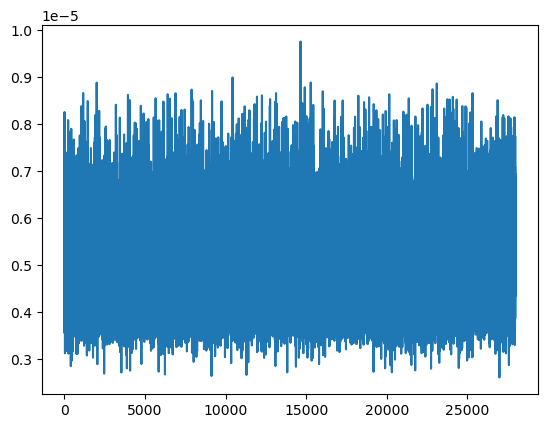

In [99]:
encoded_outputs = encoder.predict(x_test)

mse_test_preds = model.predict(encoded_outputs)
plt.plot(mse_test_preds)

In [100]:
total_loss = []
total_loss.append(mse_test_preds)
for i, signal_X in enumerate(signal_data):
    encoded_outputs = encoder.predict(signal_X)
    total_loss.append(model.predict(encoded_outputs))


4539/4539 ━━━━━━━━━━━━━━━━━━━━ 4s 855us/step
4539/4539 ━━━━━━━━━━━━━━━━━━━━ 3s 635us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 4s 856us/step
4534/4534 ━━━━━━━━━━━━━━━━━━━━ 3s 617us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 4s 895us/step
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 3s 645us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 4s 862us/step
4514/4514 ━━━━━━━━━━━━━━━━━━━━ 3s 637us/step


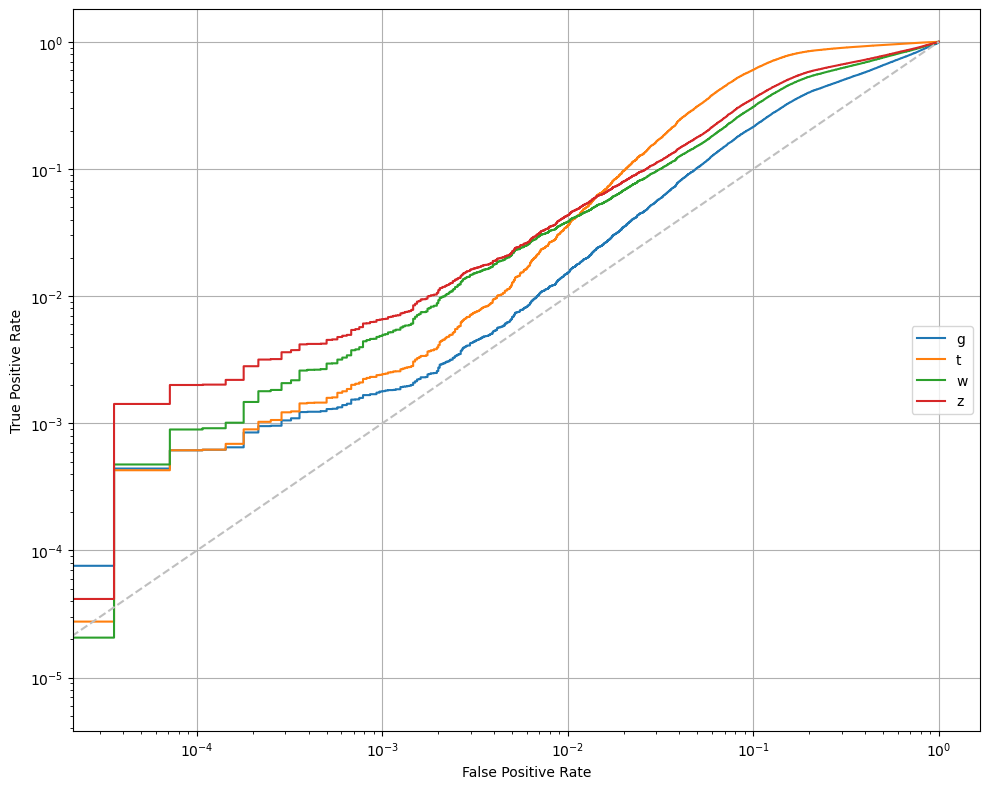

In [116]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
#plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
#plt.title(f"ROC VQ-VAE, latent_dim = {16}, embeddings = {num_embeddings}")
#plt.savefig(output_file+'_roc.jpg')
#plt.show()

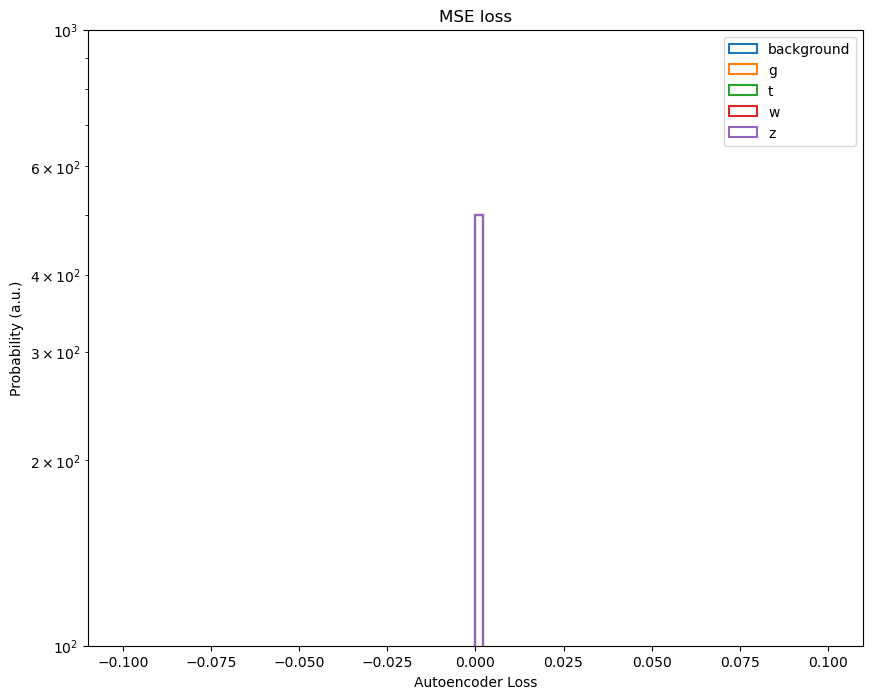

In [117]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "g", "t", "w", "z"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5, range=[-0.1, 0.1])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step


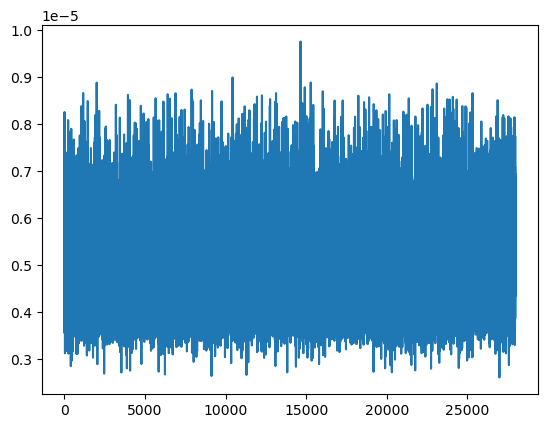

In [106]:
plt.plot(model.predict(encoder.predict(x_test)))